In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import scipy.stats
import astropy.time
import astropy.units as u
import astropy.constants as c

#style = "https://raw.githubusercontent.com/fedhere/DSPS/master/fbb.mplstyle"
#plt.style.use(style)

This homework asks you to reproduce the work in [Corral 2018](https://arxiv.org/pdf/0910.0055.pdf) which is well described, but not "reproducible". 
Corral 2018 uses a K-S test to show that at different magnitude scales the time gaps between earthquakes follows the same distribution. If true, this indicates that there is a consistent scaling law. 

The argument is a little convoluted, but it is a somewhat innovative use of the test. Corall compares the time gap between earthquakes  greater than a certain magnitude threshold with the time gaps between earthquakes above a different threshold, and finds no differences.

Remind yourself exactly what the K-S test is about :

    1 What is the test's Null Hypothsis that the K-S test tests?
    
    


For the two-sample KS-test, the null hypothesis is that the two samples are from the same distribution.

    2 What is the "statistic" or "pivotal quantity" that the test uses?
    


The pivotal quantity is $d_{12} = {\rm max}_x|C_1(x) - C_2(x)|$, where $C_1$ and $C_2$ are the cumulative distriubtions of of each sample.

    3 What does the probability distribution of this statistic depend on? 
    
   


The probability that the KS-statistic is greater than D depends on the sizes of the two samples and D.

In [2]:
# Read the earthquake csv file and take a look
earthquakes_csv = "https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW3/earthquakes.csv"
eqdata = pd.read_csv(earthquakes_csv, sep=" ")
eqdata.head()

,#YYY/MM/DD,HH:mm:SS.ss,ET,GT,MAG,Unnamed: 5,M,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Q,Unnamed: 25,EVID,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,NPH,NGRM
0,1984/01/01,01:30:57.52,eq,NaN,l,2.02,c,NaN,NaN,33.246,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1984/01/01,05:31:34.16,eq,NaN,l,2.12,c,NaN,NaN,32.945,...,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1984/01/01,06:59:05.14,eq,NaN,l,2.43,c,NaN,NaN,33.343,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984/01/01,11:10:25.29,eq,NaN,l,2.07,c,NaN,NaN,33.668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984/01/01,19:38:19.79,eq,NaN,l,2.13,c,NaN,NaN,33.963,...,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# We only care about date, time, and magnitude so let's grab only those
# columns, and rename them to something sensible.
colnames = ["#YYY/MM/DD", "HH:mm:SS.ss", "Unnamed: 5"]
new_colnames = {"#YYY/MM/DD": "date",
                "HH:mm:SS.ss": "time",
                "Unnamed: 5":"mag"}
eqdata = eqdata[colnames].rename(new_colnames, axis=1)
eqdata.head()

,date,time,mag
0,1984/01/01,01:30:57.52,2.02
1,1984/01/01,05:31:34.16,2.12
2,1984/01/01,06:59:05.14,2.43
3,1984/01/01,11:10:25.29,2.07
4,1984/01/01,19:38:19.79,2.13


In [4]:
# To complete this analysis, we need the time difference between each
# earthquake. Let's make one string object by concatenating the date and the
# time, which pandas can then read and convert into a datetime object which
# will allow us to find the time gaps.
# First we create the column of datetime strings.

# WWW There must be a vectorized way to do this...
datetime = [eqdata.iloc[i].date + " " + eqdata.iloc[i].time for i 
            in range(eqdata.shape[0])]

In [5]:
# This csv file seems to have some times measured at 60 seconds and 00 decimal
# seconds, whereas pandas expects the minute to end at 59.99 seconds. So we
# will simply replace the "60.00" part of the time strings with "59.99"
# Now we can convert this string datetime column to a column of proper
# datetime object.
eqdata["datetime"] = datetime
eqdata.datetime = eqdata.datetime.str.replace("60.00", "59.99")
eqdata.datetime = pd.to_datetime(eqdata.datetime)

In [6]:
# The stationary periods that the paper looks at. The null hypothesis says
# that there is a power law only within these stationary seismic periods. This for loop goes through these intervals.
stationary_periods = [(1984   , 1986.5),
                      (1990.3 , 1992.1),
                      (1994.6 , 1995.6),
                      (1996.1 , 1996.5),
                      (1997   , 1997.6),
                      (1997.75, 1998.15),
                      (1998.25, 1999.35),
                      (2000.55, 2000.8),
                      (2000.9 , 2001.25),
                      (2001.6 , 2002),
                      (2002.5 , 2003)]

# Use the astropy.time package to read in the decimal years properly. Then
# we convert these to a datetime object which pandas can then read.
ss = []
for t in stationary_periods:
    t0 = pd.to_datetime(ap.time.Time(t[0], format="decimalyear").datetime)
    t1 = pd.to_datetime(ap.time.Time(t[1], format="decimalyear").datetime)
    ss.append((t0, t1))

# Use a for loop and the |= operator to boolean add (OR operator) all of these
# boolean statements together. This reduces the number of lines from about 10
# to 3.
# Need to start with a boolean pandas area of the same length, so we generate
# an array of all False values by comparing the list to the year 1800. There
# are probably faster ways to initialize an array of False, but oh well.
dates = eqdata.datetime < pd.to_datetime("1800")
for i in range(len(ss)):
    dates |= (eqdata.datetime >= ss[i][0]) & (eqdata.datetime <= ss[i][1])

In [7]:
print ("There are {} earthquakes falling in the selected stationary periods".
       format(dates.sum()))

There are 18854 earthquakes falling in the selected stationary periods


In [8]:
eqGoodData = eqdata[dates]

# Make sure the rows are sorted chronologically
eqGoodData = eqGoodData.sort_values("datetime")

# Finally we can calculate the time difference between consecutive rows.
eqGoodData["dt"] = eqGoodData.datetime.diff()

# The first row has a NaT for the dt beacuse there is no time difference for
# the very first time. We can remove it.
eqGoodData = eqGoodData.iloc[1:]

# Using the describe method we can confirm that the smallest magnitude we have
# in our dataset is 2. We also see we have a maximum timegap of 1388 days,
# which we need to address.
eqGoodData.describe()

,mag,dt
count,18853.000000,18853
mean,2.399415,0 days 08:49:59.865924256
std,0.392425,12 days 18:37:22.805880915
min,2.000000,0 days 00:00:00.170000
25%,2.110000,0 days 00:45:36.680000
50%,2.290000,0 days 02:29:03.470000
75%,2.560000,0 days 05:55:12.240000
max,5.800000,1388 days 02:18:21.770000


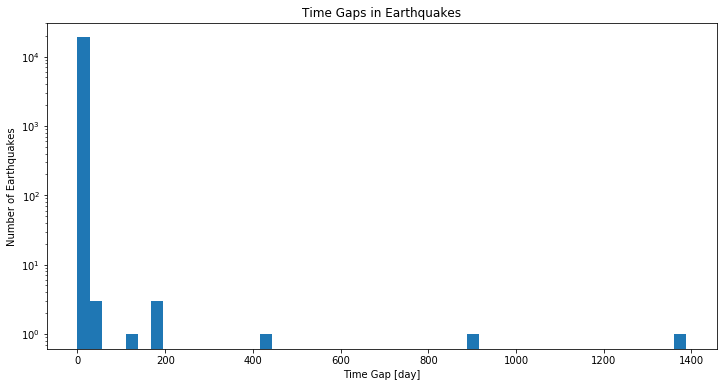

In [9]:
dt = eqGoodData["dt"].values.astype(float)
dt *= u.ns
dt = dt.to(u.day).value

fig, ax = plt.subplots(figsize=(12, 6))
plt.hist(dt, log=True, bins=50)

plt.title("Time Gaps in Earthquakes")
plt.ylabel("Number of Earthquakes")
plt.xlabel("Time Gap [day]")

plt.show()

Figure 1: The distribution of time gaps between earthquakes that occured in the stationary periods is shown. Note the timegaps larger than about a month. These are the time gaps between the stationary periods, and they should be removed.

In [10]:
day_in_ns = (30 * u.day).to(u.ns).value
eqGoodData = eqGoodData[eqGoodData["dt"].values.astype(float) < day_in_ns]
eqGoodData.shape
# We have removed 11 time gaps larger than 30 days.

(18843, 5)

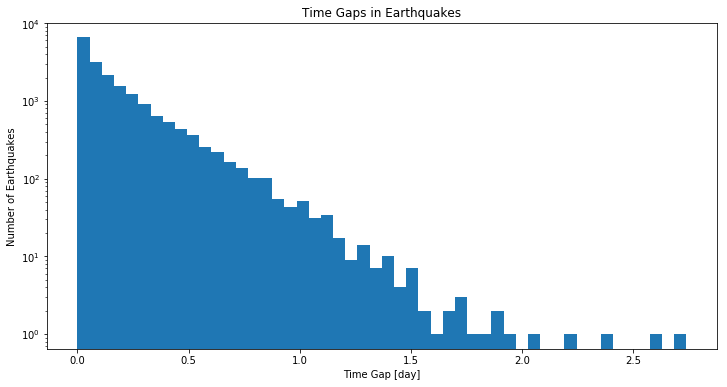

In [11]:
dt = eqGoodData["dt"].values.astype(float)
dt *= u.ns
dt = dt.to(u.day).value

fig, ax = plt.subplots(figsize=(12, 6))
plt.hist(dt, log=True, bins=50)

plt.title("Time Gaps in Earthquakes")
plt.ylabel("Number of Earthquakes")
plt.xlabel("Time Gap [day]")

plt.show()

Figure 2: The distribution of time gaps between earthquakes that occured in the stationary periods is shown where time gaps larger than 30 days have been removed.

In [12]:
def rescale(x_M, m):
    """
    Rescales time gap datasets according to Corral 2018.
    
    Arguments
    ---------
    x_M : pandas dataframe
        Dataframe consisting of just the timegaps series between earthquakes
        as datetime objects.
    m : float
        Normalized timegap threhold.
        
    Returns
    -------
    x_M : np.array
        Normalized array of timegaps.
    """
    x_M = x_M.values.astype(float)
    x_M = x_M * u.ns

    for i in range(2):
        R = 1 / x_M.mean()
        x_M = R * x_M
        x_M = x_M[x_M > m]

    return x_M

In [ ]:
alpha = 0.003  # 3 sigma p-value

m_vals = [0.01, 0.001]
M_vals = [2, 2.5, 3, 3.5, 4]

results = {m: {} for m in m_vals}
cdfs = {m: {M: 0 for M in M_vals} for m in m_vals}

for m in m_vals:
    for Mk in M_vals:
        x_Mk = eqGoodData[eqGoodData["mag"] > Mk]["dt"]
        x_Mk = rescale(x_Mk, m)

        pdf, bins = np.histogram(x_Mk, bins=2000)
        cdf = np.cumsum(pdf)
        cdfs[m][Mk] = (cdf / cdf.max(), bins[:-1])
        
    
        for Ml in [M for M in M_vals if M > Mk]:
            x_Ml = eqGoodData[eqGoodData["mag"] > Ml]["dt"]
            x_Ml = rescale(x_Ml, m)
            
            results[m][(Mk, Ml)] = (sp.stats.ks_2samp(x_Mk, x_Ml), (x_Mk.size, x_Ml.size))
            #results[m][(Mk, Ml)] = (sp.stats.ks_2samp(x_Mk, x_Ml))

 

In [ ]:
# results

| m = 0.01 | N | M >= 2.0 | M >= 2.5 | M >= 3.0 | M >= 3.5 | M >= 4.0 |
| --- | --- | --- | --- | --- | --- | --- |
|M >= 2.0 | 17176 | - | 31.7% | 56.1% | 8.7% | 18.1% |
|M >= 2.5 | 5194 | 0.015 | - | 89.7% | 20.0% | 19.7% |
|M >= 3.0 | 1311 | 0.22 | 0.17 | - | 30.8% | 17.3% |
|M >= 3.5 | 385 | 0.063 | 0.56 | 0.55 | - | 84.8% |
|M >= 4.0 | 107 | 0.104 | 0.103 | 0.109 | 0.64 | - |

| m = 0.001 | N | M >= 2.0 | M >= 2.5 | M >= 3.0 | M >= 3.5 | M >= 4.0 |
| --- | --- | --- | --- | --- | --- | --- |
|M >= 2.0 | 17895 | - | 6.4% | 9.0% | 4.6% | 14.5% |
|M >= 2.5 | 5462 | 0.020 | - | 56.5% | 16.0% | 17.5% |
|M >= 3.0 | 1401 | 0.034 | 0.023 | - | 35.1% | 20.8% |
|M >= 3.5 | 415 | 0.067 | 0.056 | 0.051 | - | 80.8% |
|M >= 4.0 | 113 | 0.106 | 0.103 | 0.102 | 0.065 | - |

Table 1: The KS-Statistic (below the diagonal) and the corresponding p-value (above the diagonal) for the rescaled earthquake data. The KS-Test was performed on samples of earthquakes with magnitude greater than 2, 2.5, 3, 3.5, and 4. Our chosen threshold to reject the null hypothesis that the two samples of timegaps between earthquakes come from the same distribution was 3-sigma, or a p-value of 0.3%. The smallest p-value observed in this analysis was 6.4% indicating that the null hypothesis cannot be rejected.

In [ ]:
markers = ["+", "x", "*", "s", "D"]

fig, ax = plt.subplots(figsize=(12, 6))
for i ,(M, cdf) in enumerate(cdfs[m_vals[0]].items()):
    plt.plot(np.log10(cdf[1]), cdf[0], linestyle="None", marker=markers[i], label=f"M > {M}")
    
plt.title("Cumulative Distribution of Time Gaps Between Earthquakes")
plt.ylabel("CDF(x)")
plt.xlabel("Earthquake Timegap (normalized)")
    
plt.legend()
plt.show()

Figure 3: The cumulative distribution function (CDF) of time gaps between earthquakes is plotted for earthquakes of magnitudes larger than 2, 2.5, 3, 3.5, and 4, with a minimum normalized time gap of 0.01. The fact that the distributions all lie on roughly the same curve is indicative of a scaling law, indicating that, no matter the magnitude, the earthquakes are being generated from the same dsitribution. This is agrees with the KS-Test results in Table 1.

### Analysis

No statistical significance was found between the distributions only because we decided beforehand that the p-value we required to reject the null hypothesis was 0.3%, and we did not observe this in the data. If we had set the p-value to 5% (2-sigma) then we could say that the distribution of time gaps between earthquakes with a magnitude greater than 2 and the distribution of time gaps between earthquakes with a magnitude greater than 3.5 would be different (see Table 1). However, in context of the rest of the analysis I would hesitate to say that the distributions were statistically different in actuality even if our alpha value was 2-sigma.

My results are not identical to Correll 2018, and this is likely because we do not have the exact same population of earthquakes. Although our conclusions were the same, which is good, our exact results differed, therefore making this paper not 100% reproducible.

---

<h1 style="color:red"> Awesome !</h1>
